In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [2]:
ns = [i for i in range(12, 21)]
k = 8
ps = [1, 2, 4, 8, 16]
num_proc = 10
batch_size = 250

In [3]:
import h5py
import torch

parent_dir = os.path.dirname(os.getcwd())
dir = f"{parent_dir}/experiments/exp2/k_8/results"

rt = {n : {p : torch.zeros(size=(num_proc * batch_size, )) for p in ps} for n in ns}

# Load and combine hdf5 files to get running times
for n in ns:
	for proc in range(num_proc):
		for p in ps:
			filename = f'{dir}/rt_{n}_{k}_{p}_{proc * batch_size}.hdf5' 
			with h5py.File(filename, 'r') as file:
				fresh = torch.from_numpy(file.get('times')[:])
				index = proc * batch_size
				rt[n][p][index : index + batch_size] = fresh

In [4]:
# Find median running times
mrt = {n : {p : torch.median(rt[n][p]) for p in ps} for n in ns}

In [7]:
import json
import numpy as np

# Coefficients from psucc
parent_dir = os.path.dirname(os.getcwd())
dir = f"{parent_dir}/experiments/exp1/k_8"
with open(f'{dir}/coeffs.json', 'r') as f:
    psucc_coeffs = json.load(f)

# Take reciprocal
psucc_coeffs = {int(p) : np.negative(c) for (p, c) in psucc_coeffs.items()}

In [15]:
mrt_coeffs = {k : {p : {} for p in ps}}

<Figure size 1500x1000 with 0 Axes>

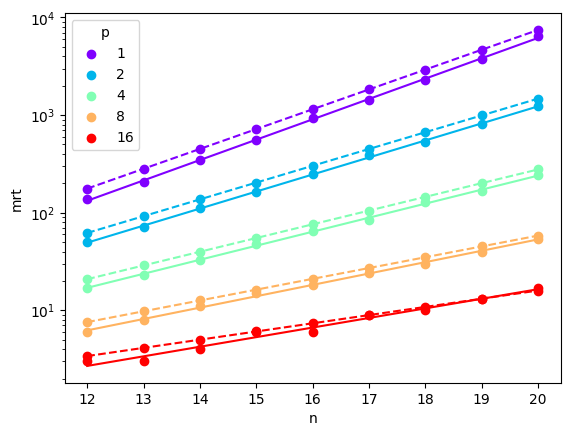

In [16]:
# Plot
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15, 10))
fig, ax = plt.subplots()

x = list(mrt.keys())
ys = [[mrt[n][p] for n in x] for p in ps]
color = iter(plt.cm.rainbow(np.linspace(0, 1, len(ps))))

for (p, y) in zip(ps, ys):
	c = next(color)
	# Points
	ax.scatter(x, y, label=p, color=c)

	# Line of best fit
	coefficients = np.polyfit(x, np.log(y), 1)
	mrt_coeffs[k][p] = list(coefficients)
	polynomial = np.poly1d(coefficients)
	ax.plot(x, np.exp(polynomial(x)), color=c)

	# Psucc lines
	psucc_polynomial = np.poly1d(psucc_coeffs[p])
	ax.scatter(x, np.exp(psucc_polynomial(x)), color=c)
	ax.plot(x, np.exp(psucc_polynomial(x)), linestyle='dashed', color=c)

ax.set_yscale('log')
ax.set_xlabel('n')
ax.set_ylabel('mrt')
ax.legend(title='p')
plt.show()

In [13]:
parent_dir = os.path.dirname(os.getcwd())
dir = f"{parent_dir}/experiments/exp4/ksat"
with open(f'{dir}/coeffs.json', 'w') as f:
    json.dump(mrt_coeffs, f)